### Author: Md Fahim Hasan
### Work Email: mdfahim.hasan@bayer.com

# ML model (GOSS-LGBM) for `Min Temperature`

##  Read Me

This scripts contains ML model building steps for the weather variable `Minimum Temperature`. The ML model has been implemented using the [Gradient-based One-Side Sampling (GOSS)](https://proceedings.neurips.cc/paper_files/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf) algorithm from [LightGBM](https://lightgbm.readthedocs.io/en/stable/) library. Detail on why GOSS has been chosen for ML modeling has been described in `Discussion.ipynb`. The modeling involves the following steps-

1. Loading Data
2. Evaluation before model performance/relationship 
3. additional data filtering 
4. train-test data split 
5. Looking into Mutual Information (MI) score to select preliminary input variables
6. Model training + hyperparameter tuning
7. Train-test dataset performance evaluation
8. Evaluating model's predictor importance plot
9. Evaluation model performance for randomly selected dates from the test dataset
10. Estimating overall model perforamcne on test dataset
11. Generating daily high-resolution data records using the trained model for an extended timeline (2002-2023)

__Note:__
- the functions for building ML model, hyperparameter optimization, model performance evaluation, and daily improved-resolution weather data generation (interpolation) can be found at `ML_utils.ipunb` script.
- the functions for building Multi-Layered Perceptrons (MLP) model with Pytorch library and generating daily improved-resolution weather datasets can be found at `NN_Pytorch.ipunb` script.
- the general functions for  for raster data handling, era5/twc data processing/compilation, and folder handling can be found at `general_utils.ipunb` script.

In [1]:
from ipynb.fs.full.general_utils import *
from ipynb.fs.full.ML_utils import *

------------------

## 1. Loading Data

The `combined dataset` parquet file consists of weather datasets from ERA5 and TWC, along with topography and lat/lon data. Importing ERA5 and TWC datasets as well to briefly look into which variables belong to which source. 

In [2]:
era5_data= '../../datasets/processed_parquet_data/cities_California/era5_parquet/4km_era5_daily_data.parquet'
twc_data= '../../datasets/processed_parquet_data/cities_California/twc_parquet/twc_historic_weatherdata.parquet'
combined_dataset =  '../../datasets/processed_parquet_data/cities_California/twc_era5_weather_data_cities_California.parquet'

twc_df =pd.read_parquet(twc_data)
era5_df = pd.read_parquet(era5_data)
combined_df = pd.read_parquet(combined_dataset)

print(f'TWC df columns: {twc_df.columns}')
print(f'ERA5 df columns: {era5_df.columns}')
print(f'TWC ERA5 df columns: {combined_df.columns}')

TWC df columns: Index(['index', 'avg_wind_speed', 'date', 'year', 'month', 'day', 'lon', 'lat',
       'avg_Rhumid', 'max_temp', 'min_temp'],
      dtype='object')
ERA5 df columns: Index(['MaxNet_SR', 'date', 'elevation', 'min_Rhumid', 'min_dew_temp',
       'max_atmPress', 'lat', 'lon', 'max_wind_speed', 'aspect', 'MaxDown_SR',
       'TotNet_SR', 'min_temp', 'max_temp', 'max_Rhumid', 'TotDown_SR',
       'min_wind_speed', 'total_precip', 'avg_wind_speed', 'eto',
       'min_atmPress', 'slope', 'avg_Cloud', 'avg_atmPress', 'max_dew_temp',
       'avg_SM_L1', 'avg_dew_temp', 'avg_wind_dir', 'avg_Rhumid', 'etr',
       'avg_ST_L1', 'avg_snow_depth'],
      dtype='object')
TWC ERA5 df columns: Index(['index', 'avg_wind_speed_twc', 'date', 'year', 'month', 'day', 'lon',
       'lat', 'avg_Rhumid_twc', 'max_temp_twc', 'min_temp_twc', 'MaxNet_SR',
       'elevation', 'min_Rhumid', 'min_dew_temp', 'max_atmPress',
       'max_wind_speed', 'aspect', 'MaxDown_SR', 'TotNet_SR', 'min_temp_era5',


---------------

## 2. Additional data filtering

__Filtering out rows after 2019-08. TWC weather data, especially temperature data has resolution issue (1 degree resolution, no intermediate float values). Therefore, not including them in model training.__

In [3]:
ml_df = combined_df[combined_df.date <=20190730]
sorted(ml_df.date)[0], sorted(ml_df.date)[-1]

(20150630, 20190730)

------------------

## 3. Evaluation before model performance/relationship

We resample 28km ERA5 `Min Temperature` data to 4km resolution and compare with TWC `Min Temperature` (4km) Data to understand how the `R2` value looks like between these variables before implementing machine learning model. 

RMSE before modeling = 2.508
R2 before modeling= 0.813


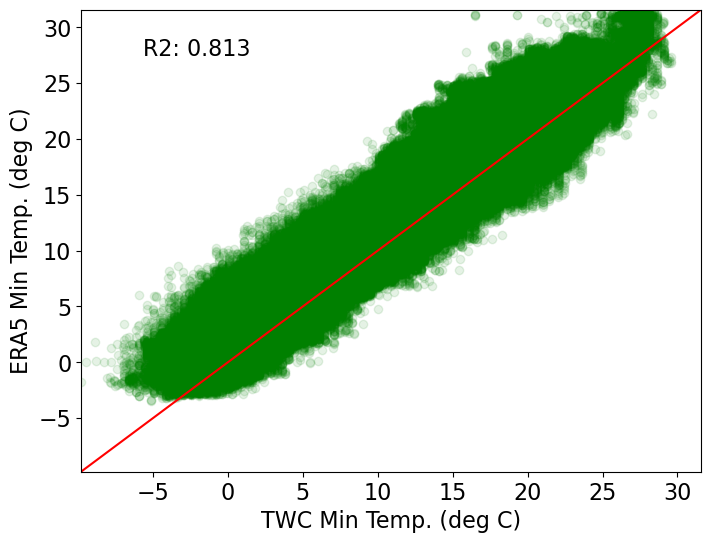

In [4]:
rmse = calculate_rmse(Y_pred=ml_df['min_temp_era5'], Y_obsv=ml_df['min_temp_twc'])
r2 = calculate_r2(Y_pred=ml_df['min_temp_era5'], Y_obsv=ml_df['min_temp_twc'])

print('RMSE before modeling = {:.3f}'.format(rmse))
print('R2 before modeling= {:.3f}'.format(r2))

scatter_plot(Y_pred=ml_df['min_temp_era5'], Y_obsv=ml_df['min_temp_twc'], 
             xlabel='TWC Min Temp. (deg C)', ylabel='ERA5 Min Temp. (deg C)', title=None, 
             savedir=None, plot_name=None, alpha=0.1, color_format='go')

## Goal

The R2 value between TWC and ERA5 min temp is quite well.However, We will try Machine Learning model to see if we can use ERA5 datasets as predictors to predict high resolution min temperature using TWC Min Temperature as the training data.

---------------------

## 4. Making train-test split

__Input variables:__ Weather variables from ERA5 renanalysis dataset, along with topography, lat/lon, month datasets, have been used as input variables/predictors in the ML model. All TWC dataset, except the training data TWC `Minimum Temperature`, has been removed from train-test datasets. 
__Observed/training data:__ TWC `Minimum Temperature` has been used as the training/observed data.

In [4]:
drop_columns = ['index', 'year', 'day',
                'avg_Rhumid_twc', 'avg_wind_speed_twc', 'max_temp_twc', 
                'avg_ST_L1', 'avg_SM_L1', 'etr', 'eto', 
                'avg_snow_depth', 'avg_wind_dir', 'min_dew_temp', 'avg_wind_speed_era5',
                'max_wind_speed', 'max_atmPress', 'min_atmPress', 'avg_atmPress', 'min_wind_speed']

x_train, x_val, x_test, y_train, y_val, y_test, train_dates, validation_dates, test_dates= \
split_train_val_test_set_by_date(input_dataset_fp=ml_df, pred_attr='min_temp_twc', 
exclude_columns=drop_columns, test_perc=0.2, validation_perc=0)

Dropping Columns- ['index', 'year', 'day', 'avg_Rhumid_twc', 'avg_wind_speed_twc', 'max_temp_twc', 'avg_ST_L1', 'avg_SM_L1', 'etr', 'eto', 'avg_snow_depth', 'avg_wind_dir', 'min_dew_temp', 'avg_wind_speed_era5', 'max_wind_speed', 'max_atmPress', 'min_atmPress', 'avg_atmPress', 'min_wind_speed'] 

Predictors: Index(['MaxDown_SR', 'MaxNet_SR', 'TotDown_SR', 'TotNet_SR', 'aspect',
       'avg_Cloud', 'avg_Rhumid_era5', 'avg_dew_temp', 'elevation', 'lat',
       'lon', 'max_Rhumid', 'max_dew_temp', 'max_temp_era5', 'min_Rhumid',
       'min_temp_era5', 'month', 'slope', 'total_precip'],
      dtype='object')


__As we are using CV for hyperparameter tuning, not creating any validation dataset.__

In [5]:
print('x_train length', len(x_train))
print('x_val length', len(x_val))
print('x_test length', len(x_test))
print(f'num. of training dates: {len(train_dates)}')
print(f'num. of validation dates: {len(validation_dates)}')
print(f'num. of test dates: {len(test_dates)}')

x_train length 1809500
x_val length 0
x_test length 452760
num. of training dates: 1175
num. of validation dates: 0
num. of test dates: 294


In [6]:
x_train.head()

,MaxDown_SR,MaxNet_SR,TotDown_SR,TotNet_SR,aspect,avg_Cloud,avg_Rhumid_era5,avg_dew_temp,elevation,lat,lon,max_Rhumid,max_dew_temp,max_temp_era5,min_Rhumid,min_temp_era5,month,slope,total_precip
0,2.763220,2.295930,23.151918,19.127819,152.862244,0.582584,26.554916,9.906414,22.050282,39.413143,-122.126717,47.560509,15.034322,41.465519,11.675686,24.098717,6,80.139702,0.069477
1,2.735067,2.274148,22.805859,18.839409,176.142258,0.593541,26.782413,10.183108,20.403061,39.413143,-122.090721,48.167271,14.924334,41.563393,11.958647,24.199512,6,89.520233,0.075222
2,2.712090,2.256796,22.491453,18.581324,179.873138,0.604181,27.072355,10.443419,20.524334,39.413143,-122.054718,48.745861,14.890730,41.603294,12.248486,24.249950,6,89.433556,0.080350
3,2.707598,2.255265,22.290098,18.431551,139.173294,0.613686,27.585321,10.645221,22.943249,39.413143,-122.018715,49.223835,15.129926,41.436172,12.562887,24.120535,6,68.663231,0.083275
4,2.822616,2.342312,24.099400,19.932610,145.411133,0.558859,26.006777,9.033833,30.534155,39.377144,-122.234718,46.599796,15.414620,41.227329,10.588063,23.672356,6,82.163490,0.033245


---------------

## 5. Looking into Mutual Information (MI) score to select preliminary input variables

`MI score` and `feature importance plot` are ways to determine which predictors are most important in predicting the target variable.  The `MI score` and `predictor/feature importance plot` have to be inspected repeatedly with differnet combinations of input variables to find the optimum set of input variables with best model performance.

min_temp_era5      1.283010
max_temp_era5      0.769379
month              0.639752
TotDown_SR         0.473966
TotNet_SR          0.437277
max_dew_temp       0.424753
MaxDown_SR         0.418990
avg_dew_temp       0.389451
MaxNet_SR          0.384384
avg_Rhumid_era5    0.267593
max_Rhumid         0.255800
min_Rhumid         0.234828
avg_Cloud          0.231936
total_precip       0.097799
elevation          0.042428
slope              0.040885
aspect             0.040008
lat                0.031772
lon                0.028561
dtype: float64

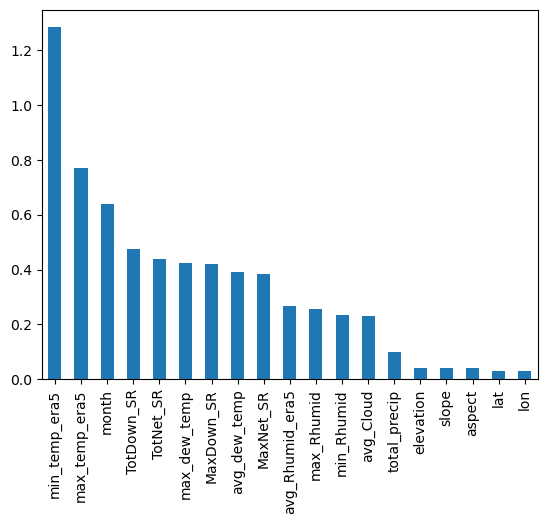

In [7]:
mutual_info_temp = calculate_plot_mutual_information(x_train=x_train, y_train=y_train)
mutual_info_temp

------------------

## 6. Model training+hyperparamter tuning

Tuned GOSS (LightGBM) model for 09 hyperparameters with 10-fold Randomized CV. A total of 500 combinations of hyperparameters were tested. The hyperparameter space can be found at `ML_utils.ipynb` script. 

In [6]:
# the hyperparameters provided in the following dictionary have been set by hyperparameter tuning
lgbm_param_dict = {'n_estimators': 250,
                   'max_depth': 13,
                   'learning_rate': 0.05,
                   'subsample': 0.7,
                   'colsample_bytree': 0.8,
                   'colsample_bynode': 0.7 ,
                   'path_smooth': 0.2,
                   'num_leaves': 70,
                   'min_child_samples': 40,
                   'data_sample_strategy': 'goss'
                  }
# when tuning hyperparameters set params_dict=None.
trained_lgbm_mintemp = train_model(x_train, y_train, params_dict=lgbm_param_dict, model='lgbm', n_jobs=-1,
                                   load_model=False, save_model=True, save_folder='./saved_models', save_name='lgbm_min_temp',
                                   # hyperparameter tuning arguments
                                   tune_hyperparameters=False, repeated_Kfold=False, n_folds=10, n_iter=50, n_repeats=5)

[LightGBM] [Info] Total Bins 4276
[LightGBM] [Info] Number of data points in the train set: 1809500, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 10.672736
Train RMSE = 0.987
Train R2 = 0.971
model training time 0.200 mins


In [7]:
trained_lgbm_mintemp

LGBMRegressor(colsample_bynode=0.7, colsample_bytree=0.8,
              data_sample_strategy='goss', deterministic=True,
              force_row_wise=True, learning_rate=0.05, max_depth=13,
              min_child_samples=40, n_estimators=250, n_jobs=-1, num_leaves=70,
              path_smooth=0.2, random_state=0, subsample=0.7,
              tree_learner='serial')

-------------

## 7. Train-test dataset perforamnce evaluation

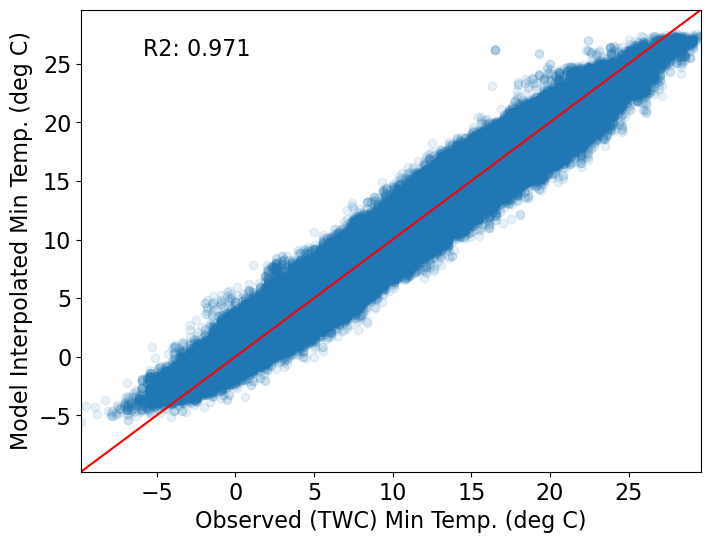

In [9]:
# Performance on train dataset
y_pred_train = trained_lgbm_mintemp.predict(x_train)

scatter_plot(Y_pred=y_pred_train, Y_obsv=y_train, 
             xlabel='Observed (TWC) Min Temp. (deg C)', ylabel='Model Interpolated Min Temp. (deg C)', title=None, 
             savedir=None, plot_name=None, alpha=0.1)

Test RMSE = 1.157
Test R2 = 0.960


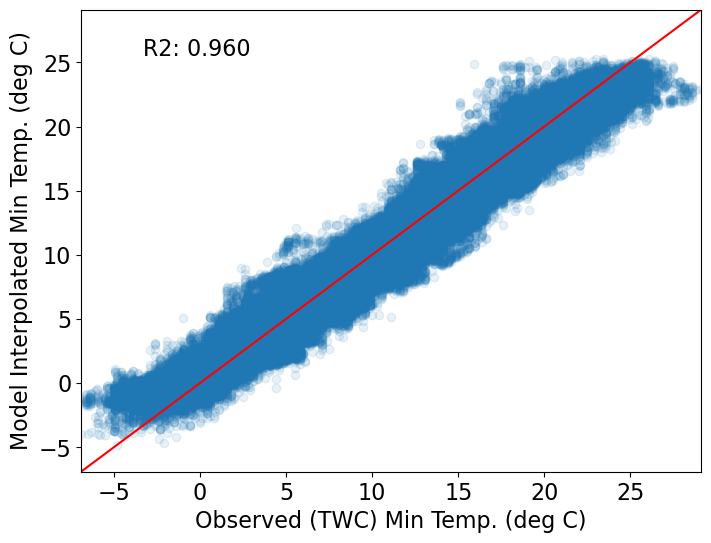

In [10]:
# Performance on test dataset
y_pred_test = trained_lgbm_mintemp.predict(x_test)
print('Test RMSE = {:.3f}'.format(calculate_rmse(Y_pred=y_pred_test, Y_obsv=y_test)))
print('Test R2 = {:.3f}'.format(calculate_r2(Y_pred=y_pred_test, Y_obsv=y_test)))


scatter_plot(Y_pred=y_pred_test, Y_obsv=y_test, 
             xlabel='Observed (TWC) Min Temp. (deg C)', ylabel='Model Interpolated Min Temp. (deg C)', title=None, 
             savedir=None, plot_name=None, alpha=0.1)

-----------------

## 8. Evaluating model's predictor importance plot

The `predictor/feature importance plot` is a way of seeing which input variables are regarded the most important by the model. The predictor importance plot here is based on `Impurity-based feature importance` which is prone to high-cardinality. I would recoomend looking into [permutation importance](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html) to have a more rigorous understanding of feature importance. The `predictor/feature importance plot` and `MI score` have to be inspected repeatedly with differnet combinations of input variables to find the optimum set of input variables with best model performance.

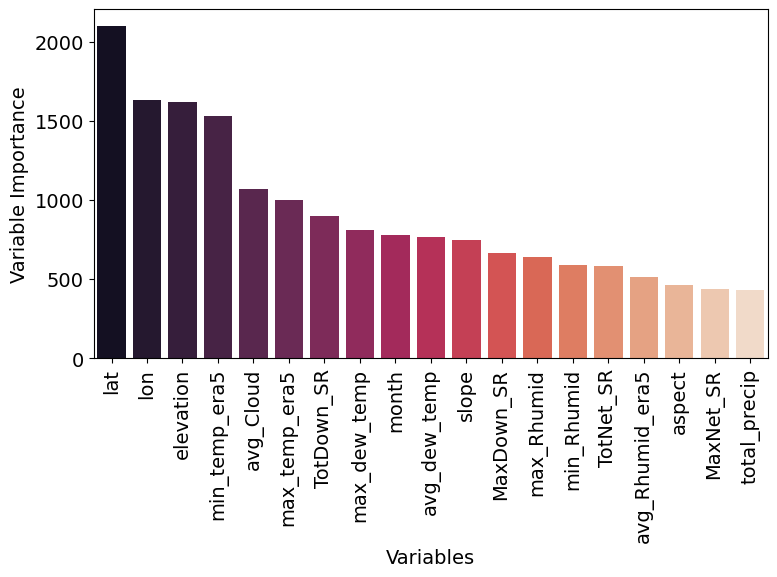

In [12]:
# preditor importance plot
plot_predictor_importance(trained_model=trained_lgbm_mintemp, x_train=x_train, outdir=None, predictor_imp_keyword='lgbm')

--------------------

## 9. Evaluation model performance for randomly selected dates from the test dataset

Our objective is to improve spatial resolution of daily weather datasets. So, we chcek model performance on randomly selected dataes from the test datasets.

__The combined dataset contains data after 2019-08 that was later filtered out in ml_df. However, we are using the combined_df (cmobined_dataset) to test performace on invidual dates which are in test dataset. Also, we are checking performance of dates after 2019-08 (with resolution issue) for which the model wasn't trained for.__

In [13]:
test_dates[1:30]

[20151213,
 20180619,
 20170617,
 20180625,
 20171005,
 20180110,
 20181015,
 20170214,
 20170123,
 20151217,
 20151020,
 20180409,
 20170203,
 20181012,
 20160419,
 20160919,
 20161007,
 20190302,
 20151006,
 20170816,
 20160802,
 20180615,
 20150814,
 20171006,
 20190107,
 20180125,
 20170507,
 20190511,
 20190407]

In [14]:
# to check if a date is in test dataset
if 20160413 in test_dates:
    print(True)

True


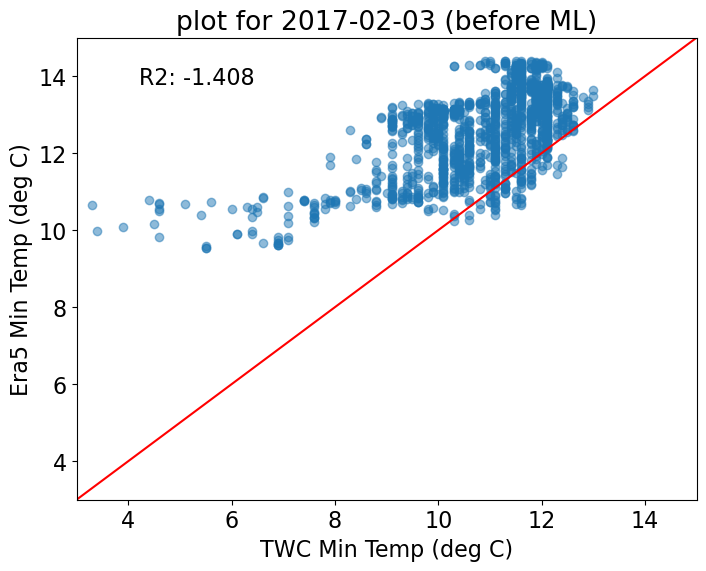

In [8]:
twc_era5_df_sample = combined_df[combined_df.date==20170203]
era5_mintemp = twc_era5_df_sample['min_temp_era5'] 
y_02 = twc_era5_df_sample[['min_temp_twc']].values

scatter_plot(Y_pred=era5_mintemp, Y_obsv=y_02, 
             xlabel='TWC Min Temp (deg C)', ylabel='Era5 Min Temp (deg C)', 
             title='plot for 2017-02-03 (before ML)', axis_lim=[3, 15])

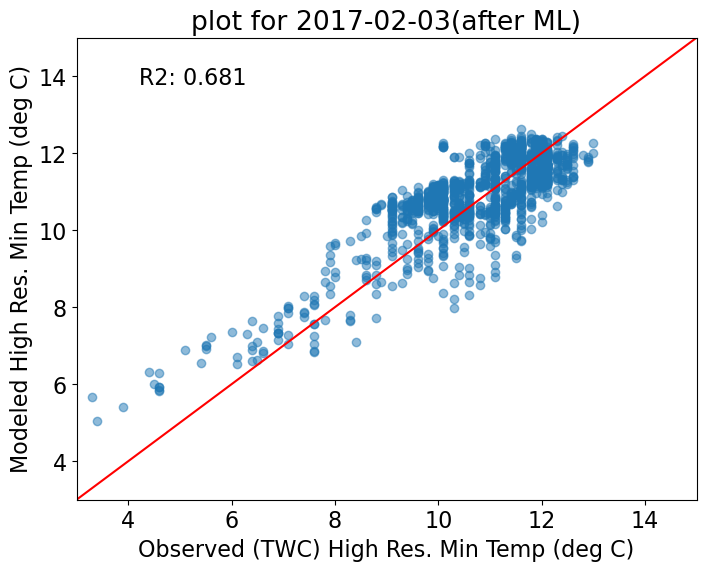

In [9]:
twc_era5_df_sample = combined_df[combined_df.date==20170203]
x_02 = twc_era5_df_sample[x_train.columns] 
x_02 = reindex_df(x_02)
y_02 = twc_era5_df_sample[['min_temp_twc']].values 

y_pred_train = trained_lgbm_mintemp.predict(x_02)

scatter_plot(Y_pred=y_pred_train, Y_obsv=y_02, 
             xlabel='Observed (TWC) High Res. Min Temp (deg C)', ylabel='Modeled High Res. Min Temp (deg C)', 
             title='plot for 2017-02-03(after ML)', axis_lim=[3, 15])

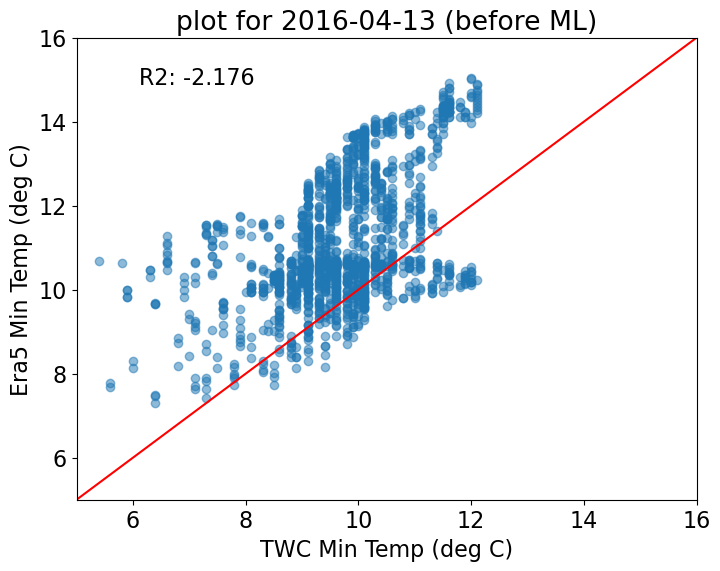

In [13]:
twc_era5_df_sample = combined_df[combined_df.date==20160413]
era5_mintemp = twc_era5_df_sample['min_temp_era5'] 
y_02 = twc_era5_df_sample[['min_temp_twc']].values

scatter_plot(Y_pred=era5_mintemp, Y_obsv=y_02, 
             xlabel='TWC Min Temp (deg C)', ylabel='Era5 Min Temp (deg C)', 
             title='plot for 2016-04-13 (before ML)', axis_lim=[5, 16])

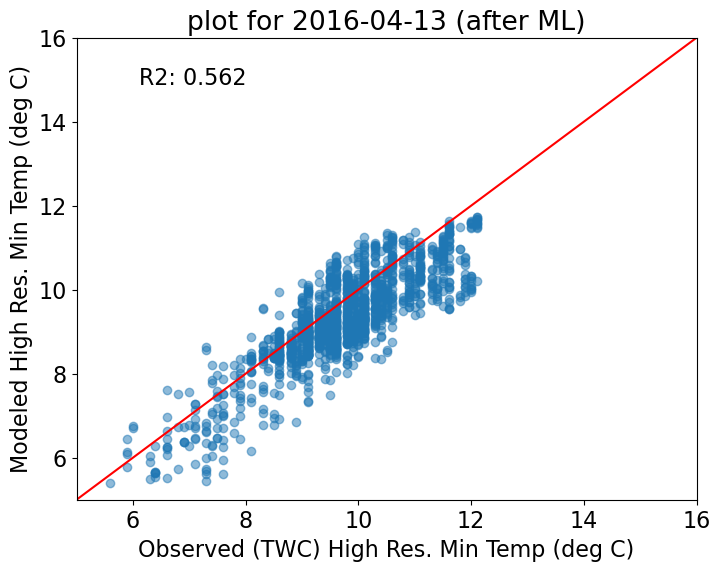

In [14]:
twc_era5_df_sample2 = combined_df[combined_df.date==20160413]
x_02 = twc_era5_df_sample2[x_train.columns] 
x_02 = reindex_df(x_02)
y_02 = twc_era5_df_sample2[['min_temp_twc']].values

y_pred_train = trained_lgbm_mintemp.predict(x_02)

scatter_plot(Y_pred=y_pred_train, Y_obsv=y_02, 
             xlabel='Observed (TWC) High Res. Min Temp (deg C)', ylabel='Modeled High Res. Min Temp (deg C)', 
             title='plot for 2016-04-13 (after ML)', axis_lim=[5, 16])

### Dates after 2019-08

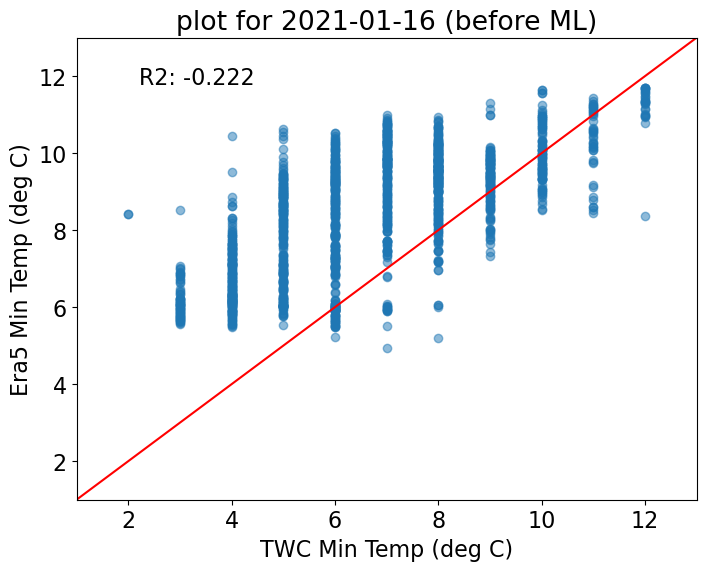

In [15]:
twc_era5_df_sample2 = combined_df[combined_df.date==20210116]
era5_mintemp = twc_era5_df_sample2['min_temp_era5'] 
y_02 = twc_era5_df_sample2[['min_temp_twc']].values

scatter_plot(Y_pred=era5_mintemp, Y_obsv=y_02, 
             xlabel='TWC Min Temp (deg C)', ylabel='Era5 Min Temp (deg C)', 
             title='plot for 2021-01-16 (before ML)', axis_lim=[1, 13])

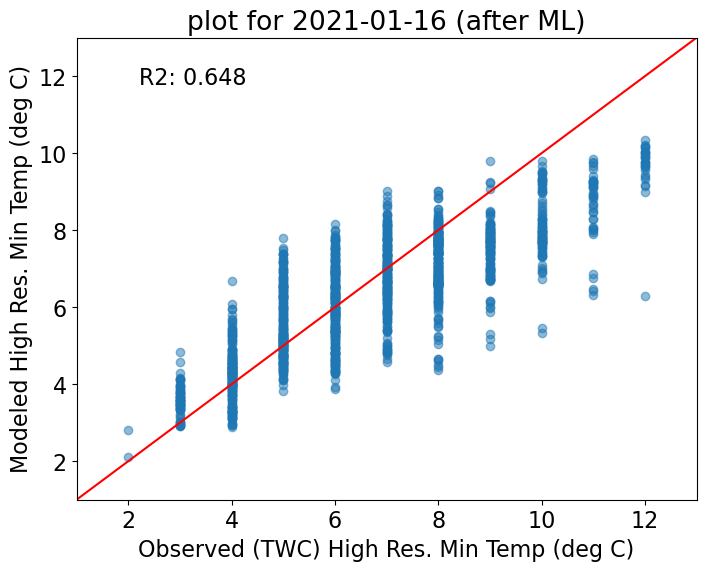

In [16]:
twc_era5_df_sample2 = combined_df[combined_df.date==20210116]
x_02 = twc_era5_df_sample2[x_train.columns] 
x_02 = reindex_df(x_02)
y_02 = twc_era5_df_sample2[['min_temp_twc']].values

y_pred_train = trained_lgbm_mintemp.predict(x_02)

scatter_plot(Y_pred=y_pred_train, Y_obsv=y_02, 
             xlabel='Observed (TWC) High Res. Min Temp (deg C)', ylabel='Modeled High Res. Min Temp (deg C)', 
             title='plot for 2021-01-16 (after ML)', axis_lim=[1, 13])

__The plots of before and after modeling performance for randomly selected dates from test dataset shows that the model is performing quite well for individual dates.__

---------------

## 10. Estimating overall model perforamcne on test dataset

Here, we are looking into before and after modeling R2 score for all dates in the test dataset.

In [21]:
result_calc_test_dataset(trained_ml_model=trained_lgbm_mintemp, list_test_dates=test_dates, x_train=x_train, 
                         combined_dataset=ml_df, era5_target_variable='min_temp_era5', 
                         twc_target_variable='min_temp_twc', 
                         output_csv='./saved_models/min_temp_test_results.csv')

294 number of total dates in test dataset
114 days have R2 > 0.6
148 days have R2 > 0.5
214 days have R2 > 0.3


,date,before_ML_R2,after_ML_R2
0,20151130,-2.885366,-0.978878
1,20151213,-0.735733,0.624928
2,20180619,-1.765327,0.714486
3,20170617,-2.792559,-0.068414
4,20180625,-1.402128,0.658351
...,...,...,...
289,20170630,-2.569831,0.758397
290,20170911,-1.464600,-0.002103
291,20181002,-0.109679,-1.039129
292,20161207,-0.567705,0.562126


In [10]:
import seaborn as sns

results_csv = './saved_models/min_temp_test_results.csv'
results_df = pd.read_csv(results_csv)

R2_below_zero_before_model = len(results_df[results_df['before_ML_R2']<0])
R2_below_zero_after_model = len(results_df[results_df['after_ML_R2']<0])

print(f'Before ML model {R2_below_zero_before_model} R2 remains negative')
print(f'After ML model {R2_below_zero_after_model} R2 remains negative')

Before ML model 270 R2 remains negative
After ML model 30 R2 remains negative


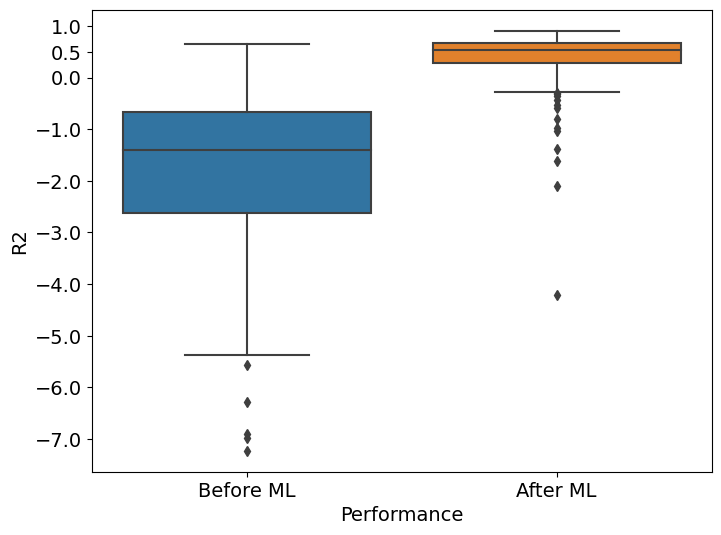

In [11]:
# Boxplot of before and after ML performance
results_df = results_df[['before_ML_R2', 'after_ML_R2']]
results_df = results_df.rename(columns={'before_ML_R2': 'Before ML', 'after_ML_R2': 'After ML'})
results_df = results_df[results_df['Before ML']>-8]

plt.rcParams['font.size'] = 14
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='variable', y='value', data=pd.melt(results_df))
ax.set_xlabel('Performance')
ax.set_ylabel('R2')
ax.set_yticks([-7, -6, -5, -4, -3, -2, -1, 0, 0.5, 1])

__The boxplot of before and after modeling R2 proves that the model is performing very well. From negative to very low R2 values, the model increases the R2 value which proves that the model interpolates the the daily weather data at high-resolution succesfully.__

-------------------

## 11. Generating daily high-resolution data records using the trained model for an extended timeline (2002-2023)

In [22]:
era5_data= '../../datasets/processed_parquet_data/cities_California/era5_parquet/4km_era5_daily_data.parquet'
ref_raster = '../../datasets/weather_raster_data/cities_California/twc_data/weather_data_4km/min_temp/min_temp_20150630.tif'
output_folder = '../../datasets/downscaled_data/4km/weather_data/modeled_4km/min_temp'

run_model_to_generate_prediction(trained_ml_model=trained_lgbm_mintemp, x_train=x_train, 
                                 predictor_era5_dataset=era5_data, ref_raster=ref_raster, 
                                 output_folder=output_folder, variable_name_keyword='min_temp')

Generating model interpolated daily rasters...
All daily rasters generated


### Visualization of downscaled results 

/tmp/ipykernel_32430/2708553209.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


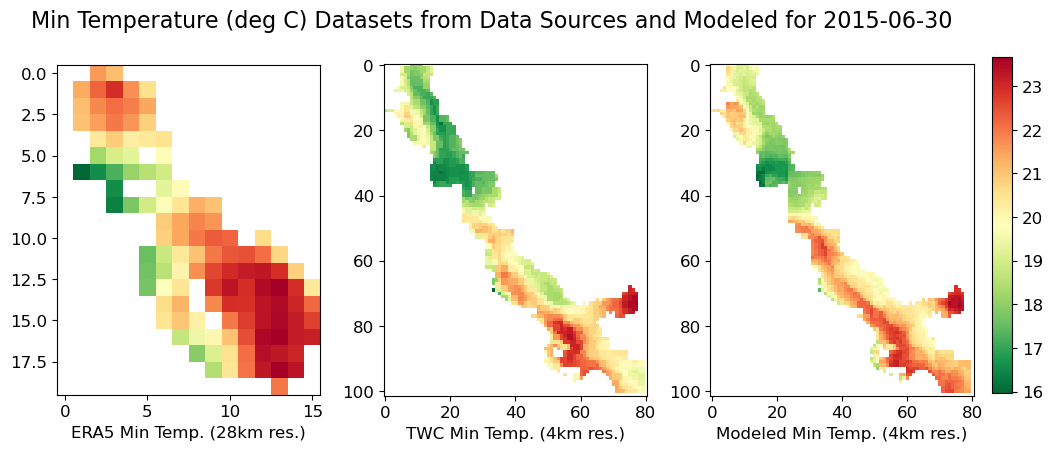

In [103]:
era5_data = '../../datasets/weather_raster_data/cities_California/era5_data/original_28km_rasters/min_temp/min_temp_20150630.tif'
twc_data = '../../datasets/weather_raster_data/cities_California/twc_data/weather_data_4km/min_temp/min_temp_20150630.tif'
downscaled_data = '../../datasets/downscaled_data/4km/weather_data/modeled_4km/min_temp/min_temp_20150630.tif'


plot_era5_twc_downscaled_rasters(era5_data, twc_data, downscaled_data,  
                                 title= 'Min Temperature (deg C) Datasets from Data Sources and Modeled for 2015-06-30',
                                 suptitle_pos=0.75,
                                 xlabels=['ERA5 Min Temp. (28km res.)',
                                          'TWC Min Temp. (4km res.)',
                                          'Modeled Min Temp. (4km res.)'],
                                 cbar_axes_pos=[1, 0.27, 0.02, 0.42])